In [1]:
import OOPAO
import tomoAO


import matplotlib.pyplot as plt
import numpy as np

from scipy.io import savemat, loadmat





     °          *      *      
 ▄██▄   ▄██▄  ▄███▄   ▄██▄ * ▄██▄ 
██* ██ ██  ██ ██  ██ ██  ██ ██  ██
██  ██ ██° ██ ██  ██ ██* ██ ██  ██
██  ██ ██  ██ ████▀  ██▄▄██ ██  ██
██* ██ ██  ██ ██     ██▀▀██ ██  ██
██  ██ ██  ██ ██ *   ██  ██ ██* ██
 ▀██▀   ▀██▀  ██   ° ██  ██  ▀██▀ 
      *         *             




In [2]:
ao_mode = "MLAO"

config_dir = "./"
config_file = "config_keck.ini"

config_vars = tomoAO.IO.load_from_ini(config_file, ao_mode=ao_mode,config_dir=config_dir)


In [3]:
savemat(f'/home/joaomonteiro/Desktop/oomao/spaceODT_reconstruction_files/params_files/Params.mat', config_vars)
params_path = f'/home/joaomonteiro/Desktop/oomao/spaceODT_reconstruction_files/params_files/Params.mat'
with open(f'/home/joaomonteiro/Desktop/oomao/spaceODT_reconstruction_files/params_files/TestName.txt', "w") as file:
    file.write(params_path)
    



## Asterism

In [4]:
from OOPAO.Source import Source
from OOPAO.Asterism import Asterism

optBand = config_vars["lgs_opticalBand"]
magnitude = config_vars["lgs_magnitude"]
lgs_zenith = config_vars["lgs_zenith"]
lgs_azimuth = config_vars["lgs_azimuth"]
lgs_altitude = config_vars["lgs_altitude"]

n_lgs = config_vars["n_lgs"]

fwhm_spot = 0.5 # arcsec
# Na Profile
n = 11 # sampling of the Na Profile
Na_profile = np.zeros([2,n])
Na_profile[0,:] = np.linspace(80000,100000,n) # altitude in m of the Na layer
Na_profile[1,:] = 1/n # Na density profile, here considered to be uniform

theta = np.linspace(0,360, n_lgs,endpoint=False) #deg

zenith = config_vars["lgs_zenith"][0]

lgsAst = Asterism([Source(optBand=optBand,
                  magnitude=magnitude,
                  laser_coordinates=[np.cos(np.deg2rad(i_theta))*13.5/2,np.sin(np.deg2rad(i_theta))*13.5/2], 
                  Na_profile=Na_profile,
                  FWHM_spot_up= fwhm_spot,
                  coordinates = [zenith,i_theta])
                  for i_theta in theta])



-------------- Source --------------
Source                   |   LGS   
Wavelength [m]           | 5.9e-07 
Zenith [arcsec]          |  7.60   
Azimuth [°]              |  0.00   
Altitude [m]             |90000.00 
Magnitude                |  8.89   
Flux [photon/m²/s]       | 2.5e+06 
Coordinates [arcsec,deg] | [7.6,0.0]
------------------------------------


-------------- Source ---------------
Source                   |   LGS   
Wavelength [m]           | 5.9e-07 
Zenith [arcsec]          |  7.60   
Azimuth [°]              |  90.00  
Altitude [m]             |90000.00 
Magnitude                |  8.89   
Flux [photon/m²/s]       | 2.5e+06 
Coordinates [arcsec,deg] | [7.6,90.0]
-------------------------------------


--------------- Source ---------------
Source                   |   LGS   
Wavelength [m]           | 5.9e-07 
Zenith [arcsec]          |  7.60   
Azimuth [°]              | 180.00  
Altitude [m]             |90000.00 
Magnitude                |  8.89   
Flux [photo

## Telescope 


------------ Telescope -------------
Diameter [m]             |  13.50   
Resolution [px]          |   288    
Pixel size [m]           |   0.05   
Surface [m²]             |   0.05   
Central obstruction [%]  |    24    
Pixels in pupil          |  61552   
Field of view [arcsec]   |  20.00   
------------------------------------

OOPAO Warning: 
A new pupil is now considered, its reflectivity is considered to be uniform. Assign the proper reflectivity map to tel.pupilReflectivity if required.


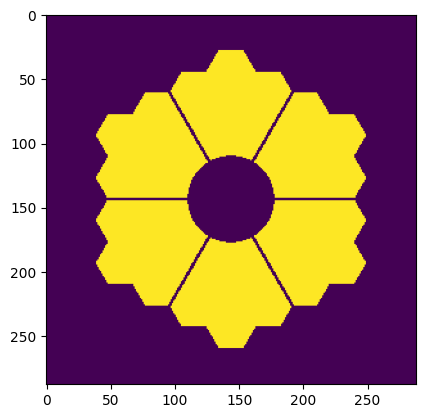

In [5]:
from OOPAO.Telescope import Telescope


sensing_wavelength  = lgsAst.src[0].wavelength           # sensing wavelength of the WFS, read from the ngs object
n_subaperture       = config_vars["nSubaperture"]        # number of subaperture across the diameter
diameter            = config_vars["diameter"]            # diameter of the support of the phase screens in [m]
resolution          = config_vars["resolution"]          # resolution of the phase screens in pixels
obs_ratio           = config_vars["centralObstruction"]  # central obstruction in fraction of the telescope diameter
sampling_time       = config_vars["samplingTime"]        # sampling time of the AO loop in [s]
fieldOfViewInArcsec = config_vars["fieldOfViewInArcsec"] # field of view of the telescope (arcsec)


tel = Telescope(diameter          = diameter,
               resolution         = resolution,
               centralObstruction = obs_ratio,
               samplingTime       = sampling_time,
               fov                = fieldOfViewInArcsec)


pupil_data = loadmat(config_vars["tel_pupil"])
pupil = pupil_data['pup'] 

tel.pupil = pupil

plt.imshow(tel.pupil)

## Atmosphere

In [6]:
from OOPAO.Atmosphere import Atmosphere

r0 = config_vars["r0"]
L0 = config_vars["L0"]

fractionnalR0 = config_vars["fractionnalR0"]
windSpeed = config_vars["windSpeed"]
windDirection = config_vars["windDirection"]
altitude = config_vars["altitude"]



atm = Atmosphere(telescope      = tel,
                 src            = lgsAst,
                 r0             = r0,
                 L0             = L0,
                 fractionalR0   = fractionnalR0,
                 altitude       = altitude,
                 windDirection  = windDirection,
                 windSpeed      = windSpeed)


atm.initializeAtmosphere(telescope=tel)

Creation of layer1/3 ...
-> Computing the initial phase screen...
initial phase screen : 0.030019283294677734 s
ZZt.. : 5.646445274353027 s
ZXt.. : 0.9060742855072021 s
XXt.. : 0.4487574100494385 s
Done!
Creation of layer2/3 ...
-> Computing the initial phase screen...
initial phase screen : 0.03751516342163086 s
ZZt.. : 6.294531345367432 s
ZXt.. : 1.0374610424041748 s
XXt.. : 0.5297744274139404 s
Done!
Creation of layer3/3 ...
-> Computing the initial phase screen...
initial phase screen : 0.03511857986450195 s
ZZt.. : 8.192264795303345 s
ZXt.. : 1.784548044204712 s
XXt.. : 0.8866655826568604 s
Done!
Updating the Atmosphere covariance matrices...

------------------------ Atmosphere -------------------------
 Layer | Direction | Speed | Altitude | Frac Cn² | Diameter |
       |    [°]    | [m/s] |   [m]    |   [%]    |   [m]    |
   1   |     0     |  5.0  |  0e+00   |    50    |  13.688  |
   2   |    30     | 15.0  |  5e+03   |    30    |  14.203  |
   3   |    70     | 25.0  |  2e+

In [7]:
lgsAst**atm*tel


--------------------------------- Asterism ---------------------------------
 Source | Wavelength | Zenith | Azimuth | Altitude | Magnitude |   Flux    |
        |    [m]     |[arcsec]|   [°]   |   [m]    |           | [ph/m²/s] |
  1-LGS |  5.9e-07   |  7.60  |  0.00   | 90000.00 |   8.89    |  2.5e+06  |
  2-LGS |  5.9e-07   |  7.60  |  90.00  | 90000.00 |   8.89    |  2.5e+06  |
  3-LGS |  5.9e-07   |  7.60  | 180.00  | 90000.00 |   8.89    |  2.5e+06  |
  4-LGS |  5.9e-07   |  7.60  | 270.00  | 90000.00 |   8.89    |  2.5e+06  |
----------------------------------------------------------------------------

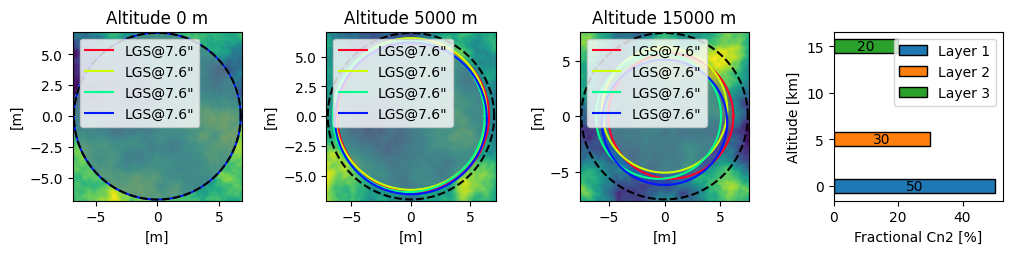

In [8]:
atm.display_atm_layers()

## ShackHartmann WFS

In [10]:
from OOPAO.ShackHartmann import ShackHartmann

shwfs = ShackHartmann(telescope          = tel,
                      nSubap             = n_subaperture,
                      lightRatio         = 0.1,
                      is_geometric       = False,
                      shannon_sampling   = True,
                      threshold_cog      = 0.01)


shwfs_geom = ShackHartmann(telescope     = tel,
                    nSubap             = n_subaperture,
                    lightRatio         = 0.1,
                    is_geometric       = True,
                    shannon_sampling   = True,
                    threshold_cog      = 0.01)



No user-input pixel scale - using shannon_sampling input value:2 pixel(s) per spot FWHM
-------------Detector--------------
Sensor type              |   CCD   
Resolution [px]          |   288   
Gain                     |    1    
Quantum efficiency [%]   |   100   
Binning                  |   1x1   
Dark current [e-/px/s]   |  0.00   
Photon noise             |  False  
Bkg noise [e-]           |  False  
Readout noise [e-/px]    |   0.0   
-----------------------------------

Selecting valid subapertures based on flux considerations..
Acquiring reference slopes..
updating the flux of the SHWFS object
Done!
Recalibrating the slopes units
Acquiring reference slopes..
Done!
Done

------- Shack-Hartmann WFS --------
Subapertures [lenslets]  |   24    
Subaperture Pitch [m]    |  0.56   
Subaperture FoV [arcsec] |  1.30   
Pixel Scale [arcsec]     |  0.108  
Valid Subapertures       |   504   
Spot Sampling [pix]      |  2.00   
Geometric WFS            |  False  
----------------------

In [11]:
unfiltered_subap_mask = np.loadtxt(config_vars["unfiltered_subap_mask"], dtype=bool, delimiter=",")
filtered_subap_mask = np.loadtxt(config_vars["filtered_subap_mask"], dtype=bool, delimiter=",")

if config_vars["filter_subapertures"]:
    shwfs.valid_subapertures = filtered_subap_mask.copy()
    shwfs_geom.valid_subapertures = filtered_subap_mask.copy()
    
else:
    shwfs.valid_subapertures = unfiltered_subap_mask.copy()
    shwfs_geom.valid_subapertures = unfiltered_subap_mask.copy()




Acquiring reference slopes..
Done!
Recalibrating the slopes units
Acquiring reference slopes..
Done!
Done

------- Shack-Hartmann WFS --------
Subapertures [lenslets]  |   24    
Subaperture Pitch [m]    |  0.56   
Subaperture FoV [arcsec] |  1.30   
Pixel Scale [arcsec]     |  0.108  
Valid Subapertures       |   464   
Spot Sampling [pix]      |  2.00   
Geometric WFS            |  False  
-----------------------------------

Acquiring reference slopes..
Done!
Recalibrating the slopes units
Acquiring reference slopes..
Done!
Done
OOPAO Warning: 
All Detector Noises are disables with the geometric WFS

------- Shack-Hartmann WFS --------
Subapertures [lenslets]  |   24    
Subaperture Pitch [m]    |  0.56   
Subaperture FoV [arcsec] |  1.30   
Pixel Scale [arcsec]     |  0.108  
Valid Subapertures       |   464   
Spot Sampling [pix]      |  4.630  
Max Elongation [arcsec]  |  7.736  
Geometric WFS            |  True   
-----------------------------------



LGS(Na) ~~> atmosphere ~~> telescope ~~> shackHartmann
LGS(Na) ~~> atmosphere ~~> telescope ~~> shackHartmann
LGS(Na) ~~> atmosphere ~~> telescope ~~> shackHartmann
LGS(Na) ~~> atmosphere ~~> telescope ~~> shackHartmann


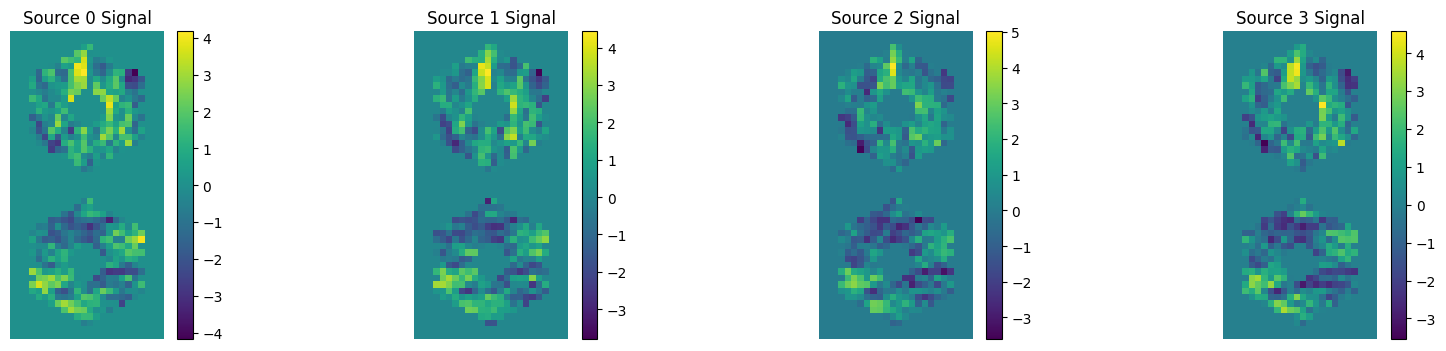

In [12]:
lgsAst**atm*tel*shwfs

lgsAst.print_optical_path()

fig, axes = plt.subplots(1, n_lgs, figsize=(20, 4))

for i in range(n_lgs):
    im = axes[i].imshow(shwfs.signal_2D[i])
    axes[i].axis('off')
    axes[i].set_title(f'Source {i} Signal')
    fig.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)


## Deformable Mirror

In [13]:
from OOPAO.DeformableMirror import DeformableMirror
from OOPAO.MisRegistration import MisRegistration


mechanical_coupling = config_vars['mechanicalCoupling']
misReg = MisRegistration(config_vars)

unfiltered_act_mask = np.loadtxt(config_vars["actuator_mask"], dtype=bool, delimiter=",")
if unfiltered_act_mask.shape[0] != config_vars['nActuator']:
    unfiltered_act_mask = np.pad(unfiltered_act_mask, pad_width=int(config_vars['nSubapExtra']/2), mode='constant', constant_values=0)


X, Y = tomoAO.tools.tomography_tools.meshgrid(config_vars['nActuator'], tel.D, offset_x=0.0, offset_y=0.0, stretch_x=1, stretch_y=1)
coordinates = np.array([X[unfiltered_act_mask], Y[unfiltered_act_mask]]).T

dm = DeformableMirror(telescope=tel,
                            nSubap=config_vars['nSubaperture'],
                            mechCoupling=config_vars['mechanicalCoupling'],
                            misReg=misReg,
                            coordinates=coordinates,
                            pitch=tel.D / (config_vars['nActuator'] - 1))


dm.unfiltered_act_mask = unfiltered_act_mask.copy()


Coordinates loaded...
Generating a Deformable Mirror: 
Computing the 2D zonal modes...

-------- Deformable mirror --------
Controlled Actuators     |   349   
M4                       |  False  
Pitch [m]                |  0.56   
Mechnical coupling [%]   |   15    
== Misregistration ================
Rotation [°]             |  0.000  
Shift X [m]              |0.000e+00
Shift Y [m]              |0.000e+00
Anamorphosis angle [°]   |  0.000  
Tangential scaling [%]   |  0.000  
Radial scaling [%]       |  0.000  
-----------------------------------



### AO System (tomoAO)


In [14]:
aoSys = tomoAO.Simulation.AOSystem(config_vars, 
                                   tel=tel, 
                                   lgsAst=lgsAst, 
                                   dm=dm, 
                                   atm=atm, 
                                   wfs=shwfs,
                                   unfiltered_subap_mask=unfiltered_subap_mask,
                                   filtered_subap_mask=filtered_subap_mask)



------------- Source --------------
Source                   |   NGS   
Wavelength [m]           | 5.9e-07 
Zenith [arcsec]          |  0.00   
Azimuth [°]              |  0.00   
Altitude [m]             |   inf   
Magnitude                |  0.00   
Flux [photon/m²/s]       | 9.0e+09 
Coordinates [arcsec,deg] | [0,0]
-----------------------------------


------------- Source --------------
Source                   |   NGS   
Wavelength [m]           | 2.2e-06 
Zenith [arcsec]          |  0.00   
Azimuth [°]              |  0.00   
Altitude [m]             |   inf   
Magnitude                |  0.00   
Flux [photon/m²/s]       | 1.9e+09 
Coordinates [arcsec,deg] | [0,0]
-----------------------------------

Coordinates loaded...
Generating a Deformable Mirror: 
Computing the 2D zonal modes...

-------- Deformable mirror --------
Controlled Actuators     |   349   
M4                       |  False  
Pitch [m]                |  0.56   
Mechnical coupling [%]   |   15    
== Misregistra

### Tomographic Reconstructor (tomoAO)


In [15]:
from tomoAO.Reconstruction.reconClassType import tomoReconstructor

rec = tomoReconstructor(aoSys=aoSys, alpha=10, os=2, 
                        order=config_vars["order"], indexation=config_vars["indexation"],
                        remove_TT_F = False,
                        filter_subapertures = config_vars["filter_subapertures"])


reconstructor = rec.reconstructor.copy()

atm.r0 = 0.16


Updating the Atmosphere covariance matrices...
GPU not available, using CPU
Updating the Atmosphere covariance matrices...


### Loop

-------------Detector--------------
Sensor type              |   CCD   
Resolution [px]          |  1152   
Gain                     |    1    
Quantum efficiency [%]   |   100   
Binning                  |   1x1   
Dark current [e-/px/s]   |  0.00   
Photon noise             |  False  
Bkg noise [e-]           |  False  
Readout noise [e-/px]    |   0.0   
-----------------------------------


------------- Source --------------
Source                   |   NGS   
Wavelength [m]           | 1.7e-06 
Zenith [arcsec]          |  0.00   
Azimuth [°]              |  0.00   
Altitude [m]             |   inf   
Magnitude                |  0.00   
Flux [photon/m²/s]       | 2.9e+09 
Coordinates [arcsec,deg] | [0,0]
-----------------------------------



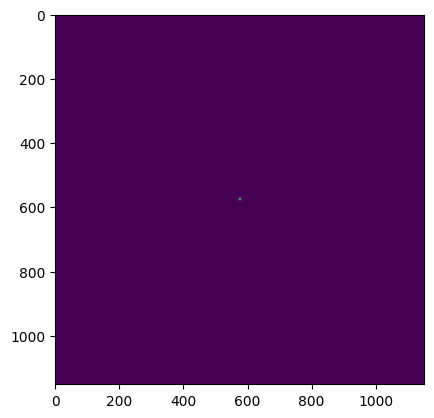


------------- Source --------------
Source                   |   NGS   
Wavelength [m]           | 5.9e-07 
Zenith [arcsec]          |  0.00   
Azimuth [°]              |  0.00   
Altitude [m]             |   inf   
Magnitude                |  0.00   
Flux [photon/m²/s]       | 9.0e+09 
Coordinates [arcsec,deg] | [0,0]
-----------------------------------



  1%|▏         | 5/349 [00:00<00:08, 41.78it/s]

updating the flux of the SHWFS object


100%|██████████| 349/349 [00:08<00:00, 41.71it/s]

Running closed loop with geometric sensor


In [16]:
from OOPAO.Detector import Detector
SciSrc_cam = Detector(tel.resolution*4)
SciSrc_cam.psf_sampling = 4
SciSrc_cam.integrationTime = tel.samplingTime*1


# Define a scientific source:
SciSrc = Source(optBand='H', magnitude=0)

dm.coefs = 0      # initialize DM commands

# initialize DM commands
SciSrc**atm*tel*dm*SciSrc_cam


nLoop = config_vars["nLoop"]

# allocate memory to save data
SR                      = np.zeros(nLoop)
total                   = np.zeros(nLoop)
residual                = np.zeros(nLoop)
wfsSignal               = np.arange(0,shwfs.nSignal*n_lgs)*0

# loop parameters
gainCL                  = config_vars["gainCL"]

atm.generateNewPhaseScreen(10)
# Save reference frame 
SciSrc**tel*dm*SciSrc_cam
plt.imshow(SciSrc_cam.frame)
plt.show()
SciSrc_cam.reference_frame = SciSrc_cam.frame.copy()



from tqdm import tqdm

if config_vars["loop_mode"] == 'closed':
    calib_src = Source('Na', 0)

    calib_src**atm
    dm_eye = np.eye(dm.nValidAct)
    imat = np.zeros((shwfs_geom.nValidSubaperture*2, dm.nValidAct)) 
    for i_act in tqdm(range(dm.nValidAct)):
        dm.coefs = dm_eye[:, i_act]*calib_src.wavelength/2/np.pi
        calib_src**tel*dm*shwfs_geom
        
        wfsSignal = np.hstack(shwfs_geom.signal)
        
        if rec.indexation == "xyxy":
            wfsSignal_xyxy = np.zeros(wfsSignal.shape)
            wfsSignal_xyxy[::2] = wfsSignal[:int(len(wfsSignal)/2)]
            wfsSignal_xyxy[1::2] = wfsSignal[int(len(wfsSignal)/2):]
            wfsSignal = wfsSignal_xyxy.copy()
            
        
        imat[:, i_act] = wfsSignal

    imat = imat*2*np.pi/calib_src.wavelength    
    imat = np.vstack([imat]*n_lgs)


print(f"Running {config_vars['loop_mode']} loop with {'geometric' if config_vars['wfs_type'] == 'g' else 'diffractive'} sensor")


In [17]:
for i in range(nLoop):

    atm.update()
    SciSrc**atm*tel

    total[i]=np.std(SciSrc.OPD[np.where(tel.pupil>0)])*1e9


    if config_vars["loop_mode"] == 'open':
        lgsAst**atm*tel*shwfs_geom*dm
        wfsSignal = np.hstack(shwfs_geom.signal)
        
    elif config_vars["loop_mode"] == 'closed':

        if config_vars["wfs_type"] == 'g':
            lgsAst**atm*tel*dm*shwfs_geom
            wfsSignal = np.hstack(shwfs_geom.signal)

        elif config_vars["wfs_type"] == 'd':
            lgsAst**atm*tel*dm*shwfs
            wfsSignal = np.hstack(shwfs.signal)
    
    

    if rec.indexation == "xyxy":

        wfsSignal_xyxy = np.zeros(wfsSignal.shape)
        wfsSignal_xyxy[::2] = wfsSignal[:int(len(wfsSignal)/2)]
        wfsSignal_xyxy[1::2] = wfsSignal[int(len(wfsSignal)/2):]
        wfsSignal = wfsSignal_xyxy.copy()


    if config_vars["loop_mode"] == 'closed':
        wfsSignal = wfsSignal-imat@dm.coefs
    
    SciSrc**atm*tel*dm*SciSrc_cam

    dm.coefs = (1-gainCL)*dm.coefs - gainCL * (reconstructor@wfsSignal)

    SR[i]=np.exp(-np.var(SciSrc.phase[np.where(tel.pupil==1)]))
    residual[i] = np.sqrt(np.var(SciSrc.OPD[np.where(SciSrc.mask==1)])) * 1e9

    
    print('Loop'+str(i)+'/'+str(nLoop)+' AO residual: '+str(residual[i])+' nm')


updating the flux of the SHWFS object
Loop0/50 AO residual: 1366.9002021829294 nm
Loop1/50 AO residual: 283.10145566411666 nm
Loop2/50 AO residual: 151.66877150392446 nm
Loop3/50 AO residual: 151.05822211016672 nm
Loop4/50 AO residual: 147.9910776704089 nm
Loop5/50 AO residual: 145.77260642741564 nm
Loop6/50 AO residual: 148.1051563821801 nm
Loop7/50 AO residual: 150.71290314073798 nm
Loop8/50 AO residual: 152.46886457214586 nm
Loop9/50 AO residual: 147.90082479879732 nm
Loop10/50 AO residual: 142.55510271025332 nm
Loop11/50 AO residual: 141.22646007682187 nm
Loop12/50 AO residual: 143.47805839837184 nm
Loop13/50 AO residual: 144.73735387173417 nm
Loop14/50 AO residual: 146.48732722730213 nm
Loop15/50 AO residual: 148.8654946800823 nm
Loop16/50 AO residual: 151.5150419674486 nm
Loop17/50 AO residual: 154.4733261938005 nm
Loop18/50 AO residual: 155.04022921288805 nm
Loop19/50 AO residual: 154.7057383992525 nm
Loop20/50 AO residual: 156.16912233962572 nm
Loop21/50 AO residual: 156.398511

## Results

In [19]:
print(f"Mean AO res {round(np.mean(residual[10:]), 2)} nm")
print(f"Mean Marechal SR: {round(np.mean(SR[10:])*100, 2)}%")
print(f"max(i_ao)/max(i_dl) SR: {round(np.max(SciSrc_cam.frame)/np.max(SciSrc_cam.reference_frame)*100, 2)}%")


Mean AO res 156.45 nm
Mean Marechal SR: 70.21%
max(i_ao)/max(i_dl) SR: 73.03%


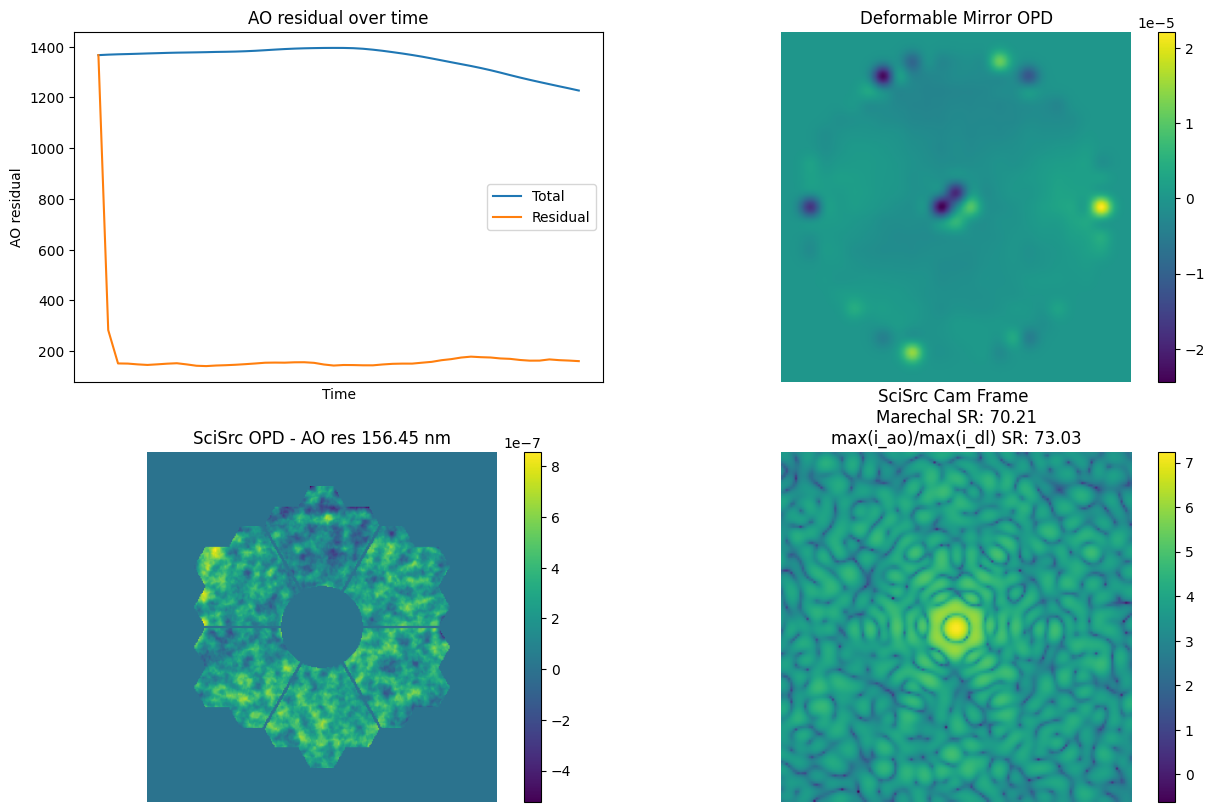

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(total, label="Total")
axes[0, 0].plot(residual, label="Residual")
axes[0, 0].set_xlabel("Time")
axes[0, 0].set_ylabel("AO residual")
axes[0, 0].set_title("AO residual over time")
axes[0, 0].legend()
axes[0, 0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)


im = axes[0, 1].imshow(dm.OPD)
axes[0, 1].axis('off')
axes[0, 1].set_title(f'Deformable Mirror OPD')
fig.colorbar(im, ax=axes[0, 1])


im = axes[1, 0].imshow(SciSrc.OPD)
axes[1, 0].axis('off')
axes[1, 0].set_title(f"SciSrc OPD - AO res {round(np.mean(residual[10:]), 2)} nm")
fig.colorbar(im, ax=axes[1, 0])


# set back the reflectivity 1
tel.pupilReflectivity = tel.pupil.astype(float)

SciSrc**atm*tel*dm 

# compute PSF method
zeroPaddingFactor = 6
tel.computePSF(zeroPaddingFactor=zeroPaddingFactor, detector=SciSrc_cam)

# get current pixel scale
size_pixel_arcsec = 206265*(tel.src.wavelength/tel.D)/zeroPaddingFactor
N                 = 500
normalized_PSF    = tel.PSF[N:-N,N:-N]# crop to zoom on the center
fov               = normalized_PSF.shape[0]*size_pixel_arcsec # get the corresponding fov


im = axes[1, 1].imshow(np.log10(normalized_PSF),extent=[-fov/2,fov/2,-fov/2,fov/2])
axes[1, 1].axis('off')
axes[1, 1].set_title(f"SciSrc Cam Frame \nMarechal SR: {round(np.mean(SR[10:])*100, 2)}\nmax(i_ao)/max(i_dl) SR: {round(np.max(SciSrc_cam.frame)/np.max(SciSrc_cam.reference_frame)*100, 2)}")
fig.colorbar(im, ax=axes[1, 1])

